In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm

# Carregando a série do spread a analisar

In [95]:
df_spread = pd.read_excel('Dados.xlsx', sheet_name='Tb_Spread').loc[:, ['Data', 'Spread médio']]
df_spread

,Data,Spread médio
0,2011-03-01,0.003814
1,2011-04-01,0.020195
2,2011-05-01,0.012077
3,2011-06-01,0.023482
4,2011-07-01,0.009526
...,...,...
160,2024-07-01,0.019996
161,2024-08-01,0.014232
162,2024-09-01,0.006048
163,2024-10-01,0.000372


# Construindo a variavel especifica de concentraçao bancaria e concessao total de credito

In [3]:
df = pd.read_json('Contratos por Fonte de Recursos e IF.json', typ='frame')

df = pd.json_normalize(df['value'])

df['Total'] = df.VlCusteio + df.VlInvestimento + df.VlComercializacao + df.VlIndustrializacao
df['Data'] = pd.to_datetime(dict(year=df.AnoEmissao, month=df.MesEmissao, day=1))

df_concessao = df.loc[:, ['Data',  'Total' ]].groupby(by=['Data'], as_index=False).sum()

df_concessao.Total = df_concessao.Total / 1000000000

df_concessao.to_excel('ConcessaoRural.xlsx')

df_ifs = df.loc[:, ['Data', 'nomeIF', 'Total' ]].groupby(by=['nomeIF', 'Data'], as_index=False).sum()

def calcular_hhi(df, data_col, volume_col):
    """
    Calcula o Índice Herfindahl-Hirschman (HHI) para cada data em um DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        data_col (str): Nome da coluna que contém as datas.
        volume_col (str): Nome da coluna que contém o volume de crédito concedido.

    Retorna:
        pd.DataFrame: DataFrame com as datas e os respectivos valores de HHI.
    """
    # Normaliza os volumes por data para calcular as participações de mercado
    df_grouped = df.groupby(data_col)[volume_col].sum().reset_index()
    df = df.merge(df_grouped, on=data_col, suffixes=('', '_total'))
    df['market_share'] = df[volume_col] / df[f'{volume_col}_total']

    # Calcula o HHI por data
    df['market_share_squared'] = df['market_share'] ** 2
    hhi = df.groupby(data_col)['market_share_squared'].sum().reset_index()
    hhi.columns = [data_col, 'HHI']

    return hhi


calcular_hhi(df_ifs, 'Data', 'Total').to_excel('ConcentracaoIFs.xlsx')

# Funçao para plotar grafico correlacionando as series

In [152]:
def plotar_series(df_serie1, nome_serie1='Spread de mercado', unidade_serie1='em %',
                  col_data1='Data', col_valor1='Spread médio',
                  df_serie2=None,nome_serie2='', unidade_serie2='',
                  col_data2='Data', col_valor2='Valor', inverte_serie2=False,
                  titulo='', observacao='', nome_arq=''):
                  

    sns.set_style("white")
    

    fig, ax1 = plt.subplots(figsize=(9, 3.5))
    

    color = 'blue'
    ax1.set_xlabel('Data')
    ax1.set_ylabel(nome_serie1+'\n'+unidade_serie1, color=color)
    ax1.plot(df_serie1[col_data1], df_serie1[col_valor1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    if df_serie2 is not None:

        ax2 = ax1.twinx()  

        color = 'brown'
        ax2.set_ylabel(nome_serie2 + '\n' + unidade_serie2, color=color) 
        ax2.plot(df_serie2[col_data2], df_serie2[col_valor2], color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        if inverte_serie2:
            ax2.set_ylim(ax2.get_ylim()[::-1])

        fig.tight_layout()  
        plt.subplots_adjust(top=0.88)
    
    plt.title(titulo)
    
    if observacao != '':
        plt.text(0.05, 0.9, observacao, transform=plt.gca().transAxes, color='k')
        
    if nome_arq != '':
        plt.savefig(nome_arq)
        
    plt.show()



# Analisa graficamente cada variavel e calcula correlações selecionando as séries mais promissoras

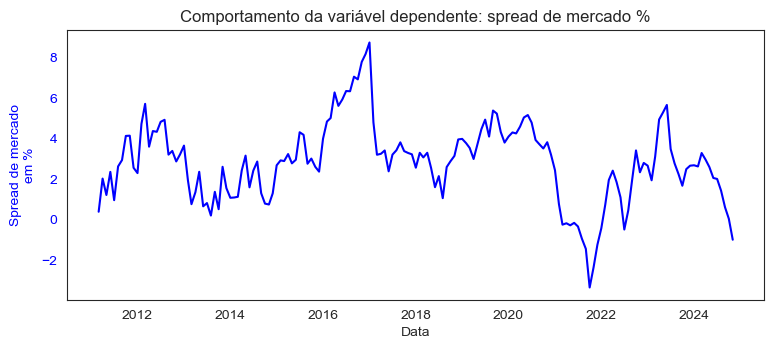

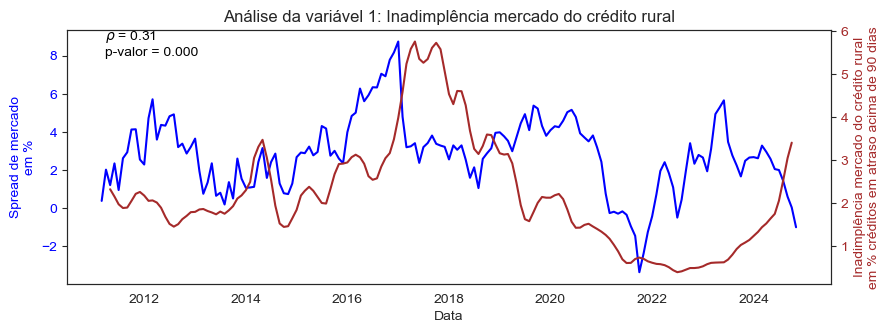

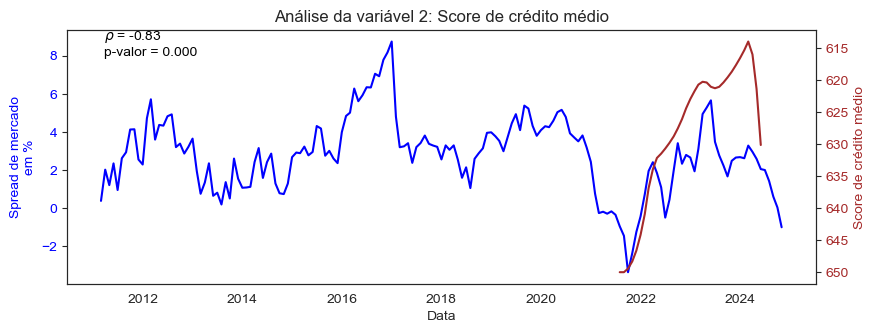

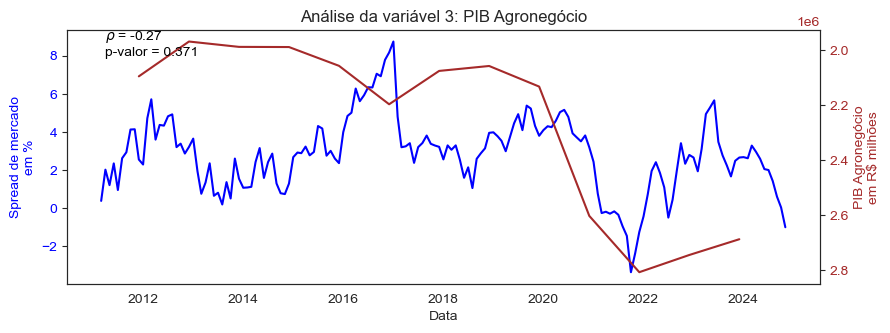

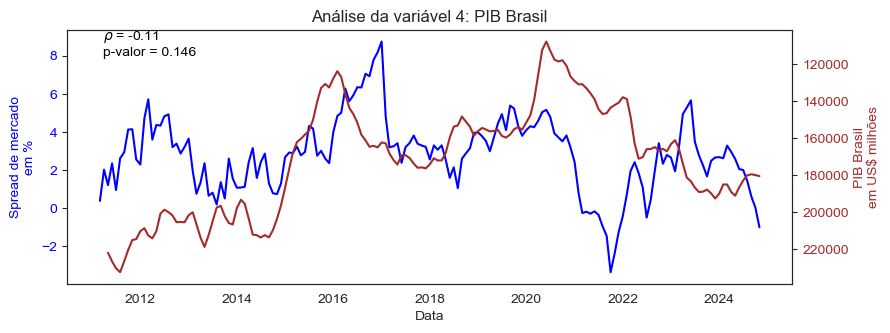

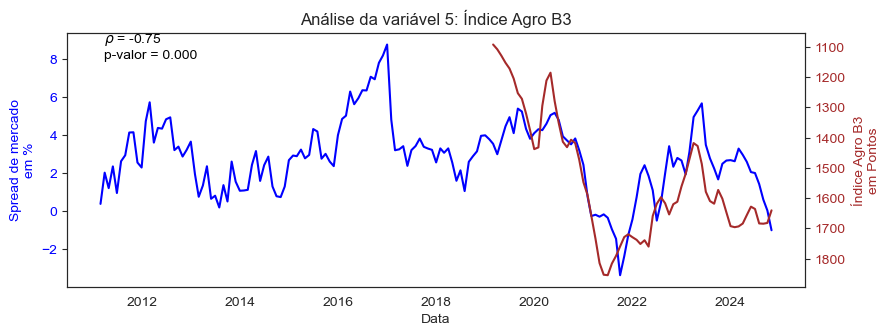

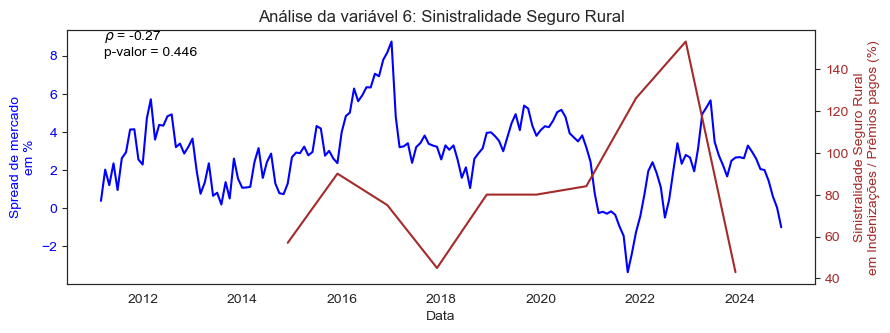

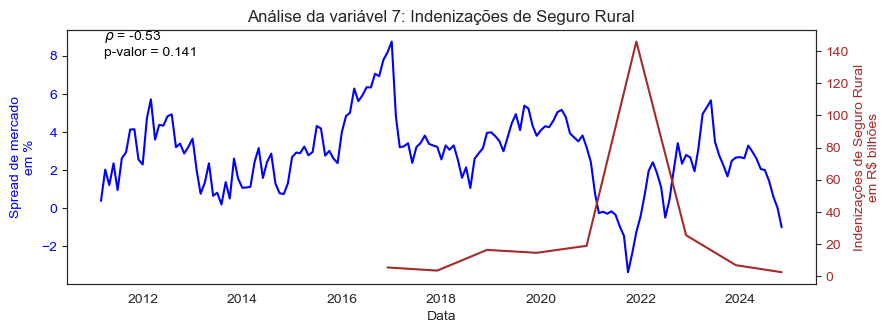

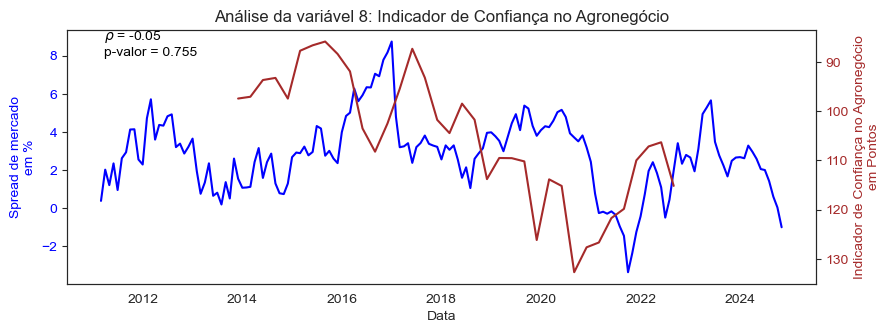

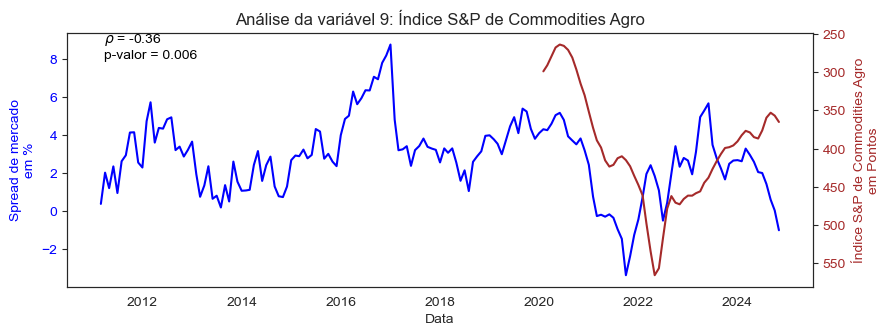

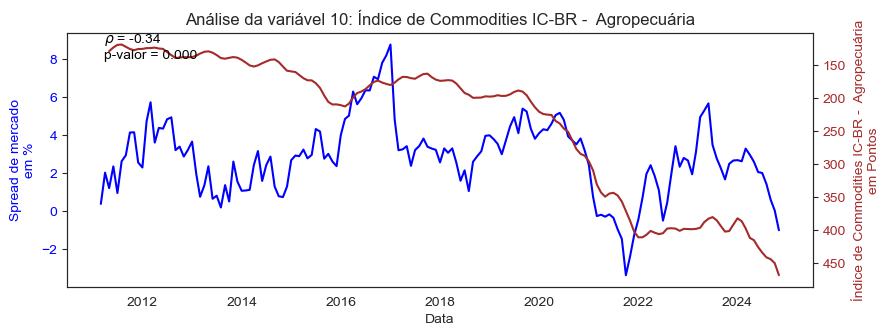

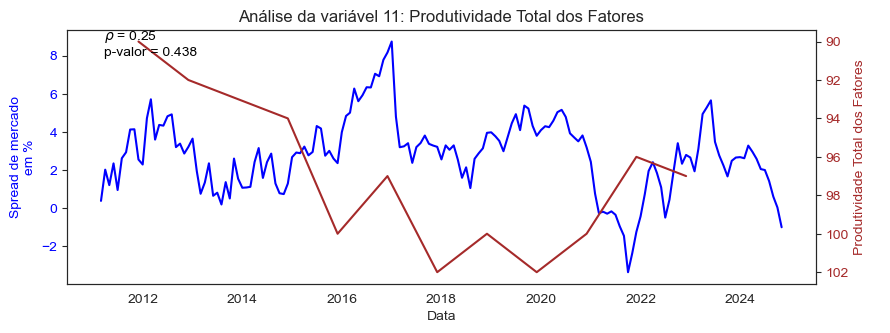

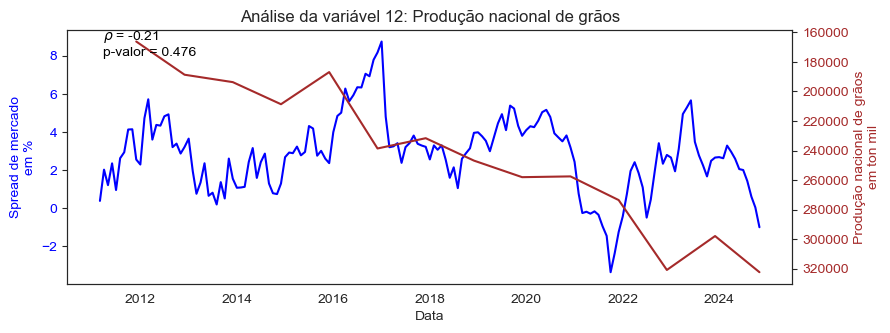

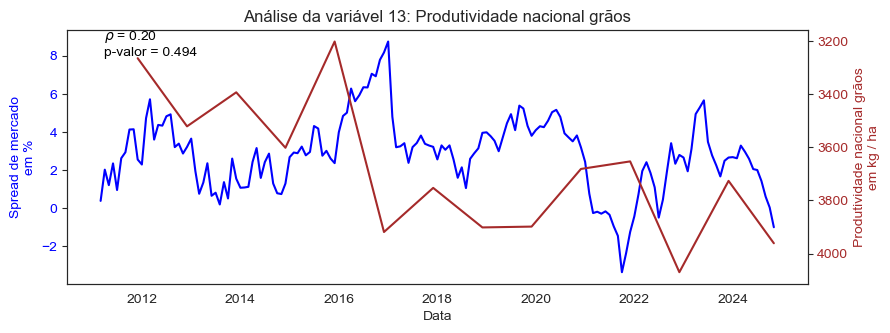

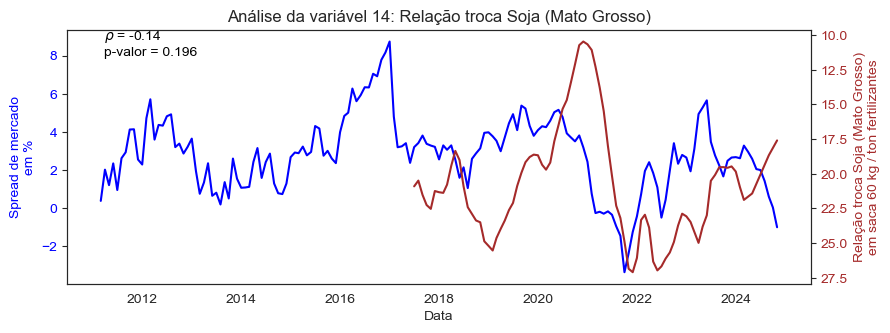

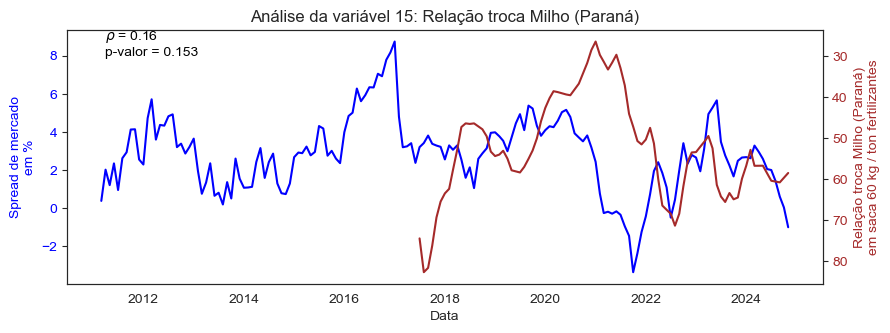

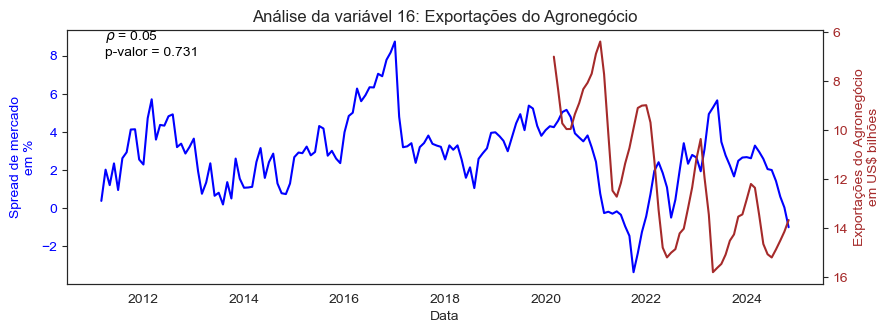

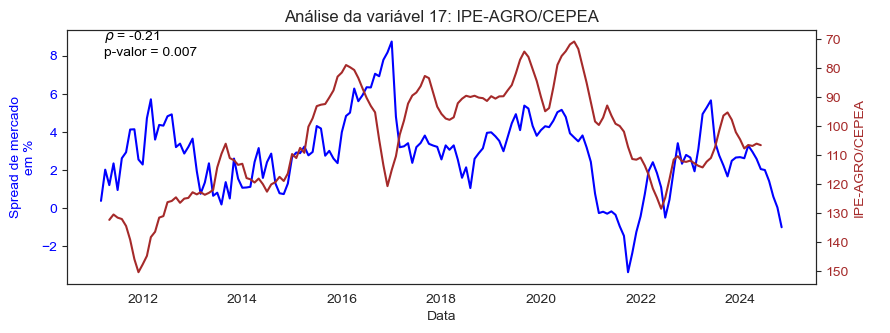

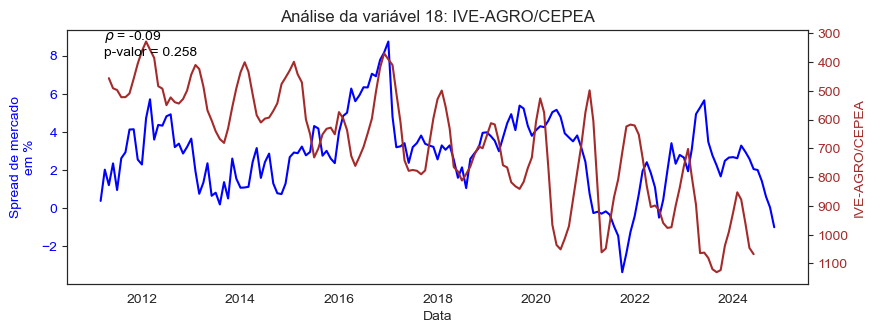

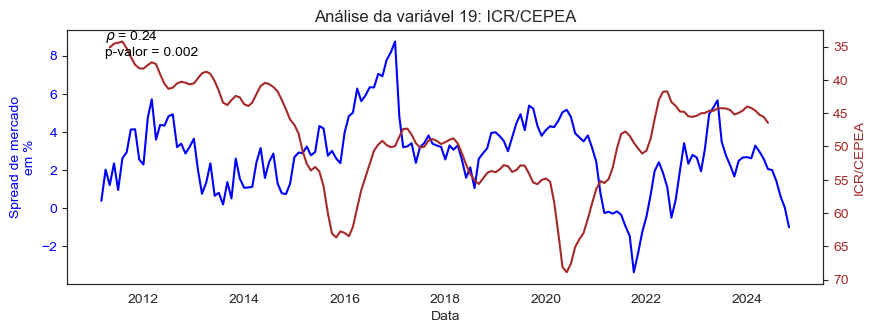

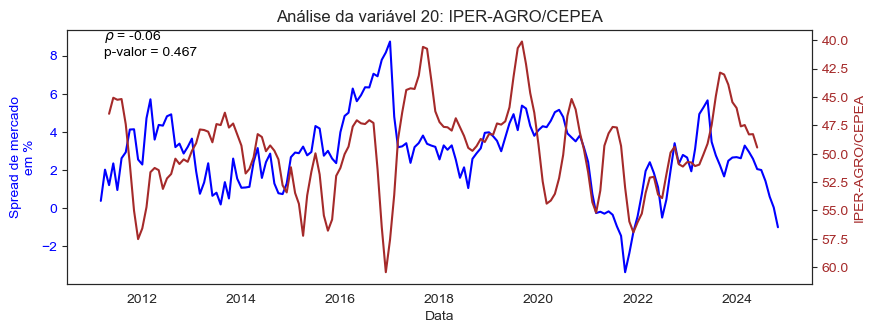

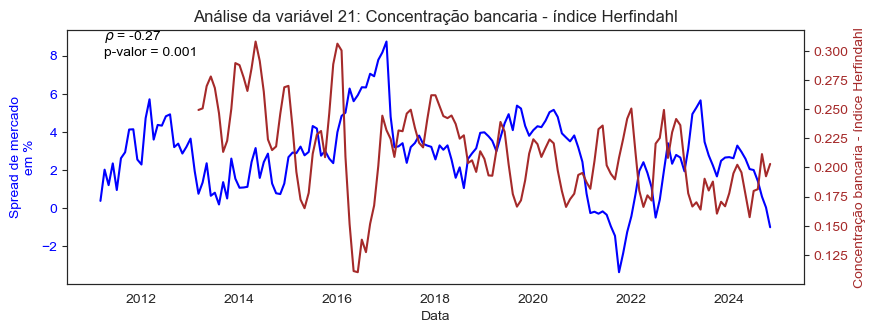

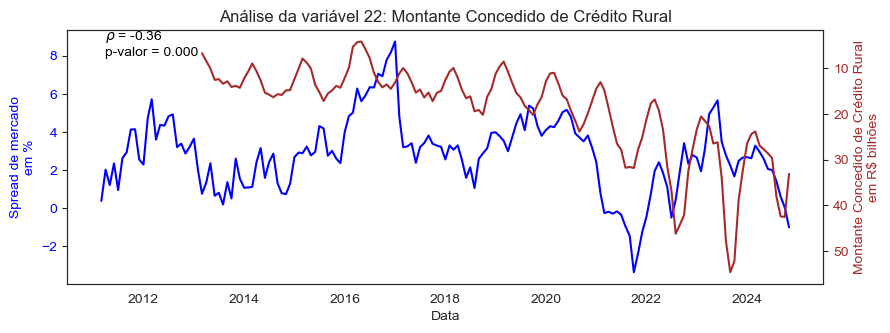

In [159]:
df_spread['Spread médio perc'] = df_spread['Spread médio']*100

plotar_series(df_serie1=df_spread, col_valor1='Spread médio perc', titulo='Comportamento da variável dependente: spread de mercado %', nome_arq='spread.png')

# comparando com as variaveis explicativas
df_series = pd.read_excel('Dados.xlsx', sheet_name='Series')
df_series = df_series[df_series['Tipo Variável']=='Explicativa']

series_selecionadas = []

for i, row in df_series.iterrows():
    id_serie = row['#']
    nome_serie = row['Nome']
    unidade_serie = row['Unidade']
    df_serie = pd.read_excel('Dados.xlsx', sheet_name=row['Tabela'])
    coluna_data = row['Coluna Data']
    coluna_valor = row['Coluna Valor']
    media_movel = False
    if row['Usar Média Móvel'] == 'Sim':
        media_movel=True
    inverte=False
    if row['Correlação Esperada'] == 'Negativa':
        inverte=True
        
    if 'Adimensional' in unidade_serie:
        unidade_serie = ''
    else:
        unidade_serie = 'em ' + unidade_serie
        
    df_cruzado = pd.merge(left=df_spread, right=df_serie, on=coluna_data, how='inner')
    
    janela_media_movel=3
    if(media_movel):
        df_cruzado = df_cruzado.loc[:, [coluna_data, 'Spread médio perc', coluna_valor]]
        df_cruzado[coluna_valor] = df_cruzado[coluna_valor].rolling(janela_media_movel).mean()
        df_cruzado = df_cruzado.dropna()
        
    correl = scipy.stats.pearsonr(df_cruzado['Spread médio perc'], df_cruzado[coluna_valor]) 
            
    observacao = r'$\rho$' + ' = ' + '{0:.2f}'.format(correl[0]) + '\np-valor = ' +  '{0:.3f}'.format(correl[1])

    plotar_series(df_serie1=df_spread, col_valor1='Spread médio perc', 
                  titulo='Análise da variável '+ str(id_serie)+': ' + nome_serie,
                 df_serie2=df_cruzado, nome_serie2=nome_serie, unidade_serie2=unidade_serie,
                  col_data2=coluna_data, col_valor2=coluna_valor,
                 inverte_serie2=inverte, observacao=observacao, nome_arq=str(id_serie)+'.png')
    
    # verifica se houve correlacao significativa e no sentido esperado
    if (correl[1] <= 0.05) and ( (inverte and correl[0]<-0.01) or (inverte==False and  correl[0]>0.01)  ):
        series_selecionadas.append({ 'Tabela' : row['Tabela'], 
                                    '#' : id_serie,
                                    'Serie' : nome_serie, 
                                    'Coluna Data' : coluna_data,
                                    'Coluna Valor' : coluna_valor,
                                    'Média Móvel' : media_movel,
                                    'Correlação' : correl[0], 
                                    'p-valor' : correl[1] })
        
    pd.DataFrame(series_selecionadas).to_excel('variaveis_selecionadas.xlsx')

# Preparando os dados para análise de regressao linear multi-variada

In [127]:
df_cruzado = df_spread.loc[:, ['Data', 'Spread médio perc']]
df_cruzado = df_cruzado.rename(columns={'Spread médio perc' : 'Spread do crédito rural'})

for s in series_selecionadas:
    df_serie = pd.read_excel('Dados.xlsx', sheet_name=s['Tabela'])
    df_serie = df_serie.loc[:, [s['Coluna Data'], s['Coluna Valor']]]
    df_serie[s['Coluna Valor']] = df_serie[s['Coluna Valor']].rolling(janela_media_movel).mean()
    df_serie = df_serie.dropna()
    df_serie = df_serie.rename(columns={s['Coluna Valor'] : s['Serie']})
    
    df_cruzado = pd.merge(left=df_cruzado, right=df_serie, on=s['Coluna Data'], how='left')
df_cruzado.to_excel('Dados_para_regressao.xlsx', index=False)
df_cruzado

,Data,Spread do crédito rural,Inadimplência mercado do crédito rural,Score de crédito médio,Índice Agro B3,Índice S&P de Commodities Agro,Índice de Commodities IC-BR - Agropecuária,IPE-AGRO/CEPEA,Montante Concedido de Crédito Rural
0,2011-03-01,0.381375,NaN,NaN,NaN,NaN,134.553333,132.260000,NaN
1,2011-04-01,2.019458,NaN,NaN,NaN,NaN,134.273333,130.406667,NaN
2,2011-05-01,1.207708,2.313333,NaN,NaN,NaN,128.636667,131.486667,NaN
3,2011-06-01,2.348175,2.143333,NaN,NaN,NaN,123.146667,131.970000,NaN
4,2011-07-01,0.952634,1.963333,NaN,NaN,NaN,119.143333,134.363333,NaN
...,...,...,...,...,...,...,...,...,...
160,2024-07-01,1.999553,2.046667,NaN,1635.886667,376.155295,434.113333,NaN,29.653374
161,2024-08-01,1.423249,2.526667,NaN,1683.716667,359.484234,441.316667,NaN,37.989234
162,2024-09-01,0.604821,3.036667,NaN,1684.580000,352.963182,444.163333,NaN,42.408973
163,2024-10-01,0.037202,3.396667,NaN,1682.070000,356.769908,450.113333,NaN,42.528311


# Realizando a regressao

Testando todas as variaveis ['Inadimplência mercado do crédito rural', 'Score de crédito médio', 'Índice Agro B3', 'Índice S&P de Commodities Agro', 'Índice de Commodities IC-BR -  Agropecuária', 'IPE-AGRO/CEPEA', 'Montante Concedido de Crédito Rural']
                               OLS Regression Results                              
Dep. Variable:     Spread do crédito rural   R-squared:                       0.809
Model:                                 OLS   Adj. R-squared:                  0.756
Method:                      Least Squares   F-statistic:                     15.14
Date:                     Mon, 30 Dec 2024   Prob (F-statistic):           1.45e-07
Time:                             18:12:39   Log-Likelihood:                -43.175
No. Observations:                       33   AIC:                             102.4
Df Residuals:                           25   BIC:                             114.3
Df Model:                                7                                 

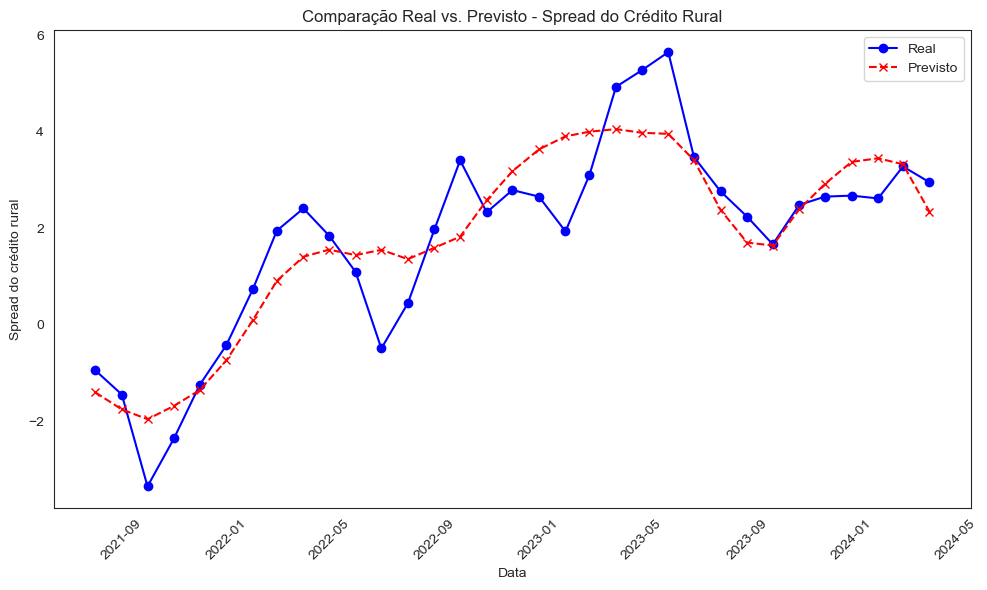

Testando variaveis selecionadas ['Score de crédito médio', 'Índice Agro B3', 'Montante Concedido de Crédito Rural']
                               OLS Regression Results                              
Dep. Variable:     Spread do crédito rural   R-squared:                       0.770
Model:                                 OLS   Adj. R-squared:                  0.747
Method:                      Least Squares   F-statistic:                     34.53
Date:                     Mon, 30 Dec 2024   Prob (F-statistic):           5.27e-10
Time:                             18:12:39   Log-Likelihood:                -48.133
No. Observations:                       35   AIC:                             104.3
Df Residuals:                           31   BIC:                             110.5
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                          co

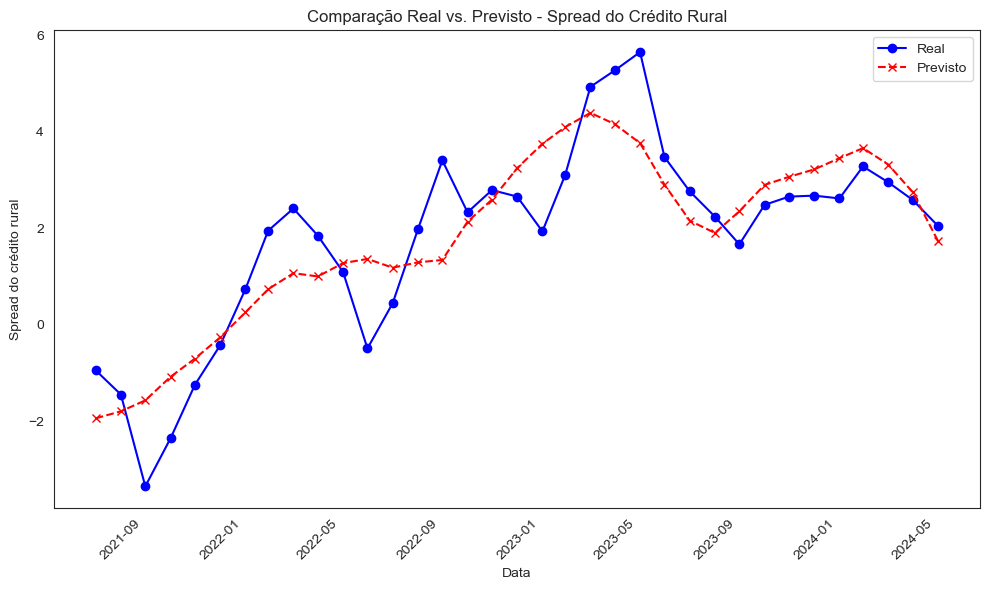

In [161]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_excel('Dados_para_regressao.xlsx')

# Selecionar variáveis explicativas
variaveis_explicativas = [
    "Inadimplência mercado do crédito rural", "Score de crédito médio", 
    "Índice Agro B3", "Índice S&P de Commodities Agro", 
    "Índice de Commodities IC-BR -  Agropecuária", "IPE-AGRO/CEPEA", 
    "Montante Concedido de Crédito Rural"
]

def regressao_spread(variaveis_explicativas):

    # Remover linhas com valores ausentes nas variáveis selecionadas
    df_limpo = df[["Data", "Spread do crédito rural"] + variaveis_explicativas].dropna()

    # Definir a variável dependente e as variáveis independentes
    X = df_limpo[variaveis_explicativas]
    y = df_limpo["Spread do crédito rural"]

    # Adicionar uma constante (intercepto) ao modelo
    X = sm.add_constant(X)

    # Ajustar o modelo de regressão linear
    modelo = sm.OLS(y, X).fit()

    # Obter o resumo do modelo
    resumo_modelo = modelo.summary()

    # Exibir o resumo do modelo
    print(resumo_modelo)

    # Previsões do modelo
    y_pred = modelo.predict(X)

    # Plotando o gráfico de comparação real vs. previsto
    plt.figure(figsize=(10, 6))
    plt.plot(df_limpo['Data'], y, label='Real', color='blue', marker='o')
    plt.plot(df_limpo['Data'], y_pred, label='Previsto', color='red', linestyle='--', marker='x')
    plt.xlabel('Data')
    plt.ylabel('Spread do crédito rural')
    plt.title('Comparação Real vs. Previsto - Spread do Crédito Rural')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

variaveis_explicativas = [
    "Inadimplência mercado do crédito rural", "Score de crédito médio", 
    "Índice Agro B3", "Índice S&P de Commodities Agro", 
    "Índice de Commodities IC-BR -  Agropecuária", "IPE-AGRO/CEPEA", 
    "Montante Concedido de Crédito Rural"
]
print('Testando todas as variaveis ' + str(variaveis_explicativas))
regressao_spread(variaveis_explicativas=variaveis_explicativas)

# realizando selecao de variaveis


def selecionar_variaveis(df, variaveis_explicativas, alpha=0.05):
    """
    Função para realizar a seleção de variáveis de forma iterativa.
    A cada iteração, removemos a variável com o maior p-valor até que todas as variáveis
    tenham p-valor menor que o valor de alpha especificado.
    
    Parâmetros:
    - df: DataFrame contendo os dados.
    - variaveis_explicativas: Lista de variáveis explicativas a serem consideradas no modelo.
    - alpha: Nível de significância para a seleção das variáveis (default é 0.05).
    
    Retorna:
    - modelo: O modelo ajustado com as variáveis selecionadas.
    - variaveis_selecionadas: O conjunto final de variáveis selecionadas.
    """
    # Inicializar o conjunto de variáveis com todas as explicativas
    X = df[variaveis_explicativas]
    y = df["Spread do crédito rural"]
    
    # Adicionar a constante (intercepto) ao modelo
    X = sm.add_constant(X)
    
    # Ajustar o modelo de regressão linear
    modelo = sm.OLS(y, X).fit()
    
    # Verificar se todas as variáveis têm p-valor menor que alpha
    while modelo.pvalues.max() > alpha:
        # Identificar a variável com o maior p-valor
        variavel_maior_p = modelo.pvalues.idxmax()
        
        # Remover a variável com o maior p-valor
        X = X.drop(columns=[variavel_maior_p])
        
        # Ajustar o modelo novamente com as variáveis restantes
        modelo = sm.OLS(y, X).fit()
        
    # Retornar as variáveis selecionadas e o modelo ajustado
    return modelo, X.columns

# executando a selecao

# Selecionar as variáveis explicativas
variaveis_explicativas = [
   # "Inadimplência mercado do crédito rural",   ## modelo apresentou inversao e por isso retirado
    "Score de crédito médio", 
    "Índice Agro B3", "Índice S&P de Commodities Agro", 
    "Índice de Commodities IC-BR -  Agropecuária", "IPE-AGRO/CEPEA", 
    "Montante Concedido de Crédito Rural"
]

# Remover linhas com valores ausentes nas variáveis selecionadas
df_limpo = df[["Data", "Spread do crédito rural"] + variaveis_explicativas].dropna()

# Aplicar o algoritmo de seleção de variáveis
modelo_selecionado, variaveis_selecionadas = selecionar_variaveis(df_limpo, variaveis_explicativas)

# Apresentar resultado do modelo selecionado

variaveis_selecionadas = list(variaveis_selecionadas)
variaveis_selecionadas.remove('const')
print('Testando variaveis selecionadas ' + str(variaveis_selecionadas))
regressao_spread(variaveis_explicativas=variaveis_selecionadas)
